<img src="pictures/logo_epfl.png" width=200/>

# Final Project - Basics of Mobile Robotics 

**Authors:** Valentin Suppa-Gallezot, Mehdi El Bouari, Thibault Golaz, Louis Marchand  


<img src="pictures/thymio_intro.jpg" width=400/>

### Table of Contents <a class="anchor" id="table"></a>

* [0. Introduction](#Introduction)
    * [0.0 Guidlines](#Guidlines)
    * [0.1. General overview of the code](#G_O)
    * [0.2. Setup of the map](#map)
    * [0.3. Essensial Library and inclusion](#library)

* [1. Vision](#vision)
    * [1.0 Most important function in Vision](#vis_function)
    * [1.1. Start and target Detection](#start_detect)
    * [1.2 Hough Transform](#hough)
    * [1.3 Template matching](#template)

* [2. Global Navigation](#global_nav)
    * [2.0. Main functions](#global_function)
    * [2.1. PyVisgraph library](#pyvisgraph)
    * [2.2 Implementation of the code](#global_code)
        * [2.2.1. The Dijkstra's algorithm](#djisktra)
        * [2.2.2. Visibility graph](#visibility)
        
* [3. Motion Control](#motion)
    * [3.0 Astolfi Controller](#astolfi)
    * [3.1 Auxiliary control functions ](#control_aux)

* [4. Local obstacle avoidance ](#local_avoidance)

* [5. Filtering](#filtering)

* [6. Whole code](#whole_code)

* [7. Conclusion](#conclusion)

## 0. Introduction <a class="anchor" id="Introduction"></a>

### 0.0. Guidlines <a class="anchor" id="Guidlines"></a>

For this project we had to construct and implement a mobile robot able to perform path finding method and movement based on vision-oriented programs. The robot we are using here is a Thymio-II robot.
  
The code will follow these guidelines:   
  
- **Create an environnment:** Our environnement is made of the thymio detectable thank to 2 green circles, obstacles (represented as black sheets of paper), a target represented by a red square of paper and 3d obstacles used to test local navigation (detected by the thymio sensors).  

- **Find the best path:** The objective is that the Thymio goes its initial position in the map to a target in the environement.  
- **Motion control:** To control the robot we use functions to correct the angle and close the position to the next goal that is updated upon reach.  

- **Kalman filter:** In the case where we don't have data from the camera we use, we apply a Kalman filter knowing the last detected/predicted position and the speed given by the robot to compute the next position.  

- **Local navigation:** While moving, the Thymio has to use local navigation to avoid physical obstacles that can be put in its path at any point in time.  


### 0.1. General overview of the code <a class="anchor" id="G_O"></a>

<img src="pictures/Diagram.png" width=700/>

On the previous diagram you can see the global architechture of the code that we have divided in five parts. They are the following: Vision, Global_Navigation, Filtering, Local_Navigation and motion control. These part will be studied in details in the next chatpers.  

We have made a class corresponding to our thymio to have a simpler acces to his state, attributes and methods. Moreover we decided to choose a finite state machine approach for the general structure of the code. During the main while (i.e the time the video flow is opened) the state of the robot (_self.state_) is evaluated to make it more responsive.  
The machine states are the following:  

- **State 0 :** In this step we are just after the opennig of the video's flow and the instanciation of the thymio, we have yet to visualize the obstacles, target and thymio initial position. We use some hough transforms and template matching to detect the obstacles, the circles representing the thymio, and the red square for the target. Once the data are transmited to the global_navigation functions, we can compute the visibility graph and compute the shortest path using a Djisktra algorithm (All these step are implemented in the PyVisgraph library). The path is represented by a list of points that need to be reached to go to the target. These points are at a certain distance from the obstacle and ensure a self travel is attained  

- **State 1 :** In this state we receive the Thymio's position if it is detected by the camera or apply a kalman filter to the las known position using the spped value returned by the thymio. We use the path computed during the state 0 to evaluate the next goal to be reached. If we exceed the lenght of the path, we go in the state 2 and the robot stops. In our code _i_ represent the next checkpoint we aim for. Once we have the starting point and the final point we can use an astolfi controller implemented in the Motion_Control part. If the sensors of the robot detect an obsatcle we use the potential field method to avoid it. This step of local avoidance is coded in the astolfi controller and enable the thymio to avoid the obstacle while still targeting the next goal.
 
- **State 2 :** This state represent the final step of the robot. In this step he robot stops and we shutdown the video flow and the computer window.    

The whole code is explained here in the form of a pseudo code:

### 0.2. Setup of the map <a class="anchor" id="map"></a>

For our map we use different elements:
- the obstacles in the form a black 2D polygons
- the target in the form of a red square 
- the thymio with is covered by two green circles
- Obstacles for local avoidance in the form of any 3d solids visible by the robot's sensors

<figure>
  <img src="pictures/map2.png" width="500" alt="map" />
  <figcaption> <center> <u>Figure 1:</u> Map of the setup for the robot<center> </figcaption></figure>

<figure>
  <img src="pictures/setup.jpg" width="500" alt="map" />
  <figcaption> <center> <u>Figure 2:</u> Setup of the camera <center> </figcaption></figure>

### 0.3. Essensial Library and inclusion <a class="anchor" id="library"></a>

#### Premade libraries

In [178]:
import cv2 
import time
import math
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point, LineString
import pyvisgraph as vg
from geopandas import GeoSeries

#### Homemade functions

In [179]:
import Vision.vision as vs
import robot as rbt
import Global_Navigation.global_navigation as glb
import Motion_Control.thymio_control as ctrl

[Table of content](#table)

## 1. Vision  <a class="anchor" id="vision"></a>

### 1.0 Most important function in Vision  <a class="anchor" id="vis_function"></a>

| Function of Vision | Input | Output |
|:------|:------|:------|
|`detect_start(image, show=False, begin = True)` |receive a frame when the program starts, show allows to plot the image and begin allows to get only the start_coordinates|An image with a white rectangle on the two circles of the thymio and the start coordinates|
|`detect_target(image)`|receive a frame when the program starts|An image with a white rectangle on the target and the coordinates of the target|
|`detect_obstacle(image)`|receive an image with white rectangle on the start and the target|corner coordinates of each obstacle|

### 1.1. Start and target Detection   <a class="anchor" id="start_detect"></a>

In order to obtain the starting point and the target point, we used two colored circles (1 blue and 1 green) of different sizes. These two circles are placed on the robot. At the beginning of the program, a picture of the scene is taken. Using the library opencv and more precisely the function template matching the center of the two circles are detected. Then by just computing the middle of these centers the center of the thymio (called starting point in the program is detected). Two circles are needed because in the following of the code it will allow to compute the orientation of the thymio  
The same method is used to get the target but a red rectangle is used instead.

Since the starting point and the goal are detected it is time to compute the coordinates of the obstacle on the map. In our project the obstacles are black 2 dimensions shapes. They are positionned randomly on the field. In order to detect them the image is converted in black and white. To avoid some risk of confusion with the shapes on the thymio and the one for the target, white rectangles are drawn on them. Then, after applying the threshold, the obstacle are detected (#plot image). By using an opencv function, the coordinates of the contours are found. Finaylly by following the steps of this link https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv every corner coordinates of each shape are stored in a array. It will be helpful to compute the visibility graph.  

### 1.2 Hough Transform:   <a class="anchor" id="hough"></a>

The Hough transform is a feature extraction technique used in image processing and computer vision. It is used to detect lines and other geometric shapes in images. The transform is named after its inventor, Paul Hough, who developed it in the 1950s.  

The Hough transform works by taking an image as input and transforming it into a new representation, known as Hough space, which encodes the geometric properties of the image. In this space, lines and other shapes are represented as points, which makes it easier to identify and extract them from the image.  

To use the Hough transform, the image is first converted into a binary image, where each pixel is either black or white. This is done by applying a threshold to the pixel intensities, so that pixels with intensities above the threshold are set to white and pixels below the threshold are set to black.  
 
Next, the Hough transform is applied to the binary image to create the Hough space. In this space, each point represents a possible line or shape in the image. The points are then grouped together into clusters, with each cluster representing a line or shape in the original image.  

Finally, the line or shape is extracted from the image by selecting the cluster with the most points and drawing a line or shape that passes through those points. This line or shape is then overlaid onto the original image to highlight the detected feature.  

The Hough transform is a powerful and widely used technique in image processing and computer vision. It is used in a variety of applications, such as identifying objects in images, detecting edges and lines in images, and extracting geometric features from images.  

<figure>
  <img src="pictures/hough.png" width="700" alt="map" />
  <figcaption> <center> <u>Figure 3:</u> Hough's transform <center> </figcaption></figure>

In [180]:
def detect_start1(image, begin=True):
    img = image.copy()
    points = []
    rayon = []

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.medianBlur(gray, 5)

    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                 cv2.THRESH_BINARY, 11, 3.5)

    # Remove unwanted noise
    kernel = np.ones((3, 3), np.uint8)
    gray = cv2.erode(gray, kernel, iterations=1)
    gray = cv2.dilate(gray, kernel, iterations=1)

    # circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10, param1=25, param2=19, minRadius=0, maxRadius=18) #Perform HoughCircle Transform
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=25, param2=25, minRadius=10, maxRadius=50)

    #print(circles)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        for (x, y, r) in circles:
            cv2.circle(img, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(img, (x - int(1.4 * r), y - int(1.4 * r)), (x + int(1.4 * r), y + int(1.4 * r)),
                          (255, 255, 255), -1)
            pos = (int(x), int(y))
            points.append(pos)
            rayon.append(r)

    test_detect = False # sera utile pour le kalman, false si la pos du thymio nest pas detetc
    center1 = 0
    center2 = 0
    start_coordinates = 0
    if len(points) == 2:
        test_detect = True
        start_coordinates = ((points[0][0] + points[1][0]) / 2, (points[0][1] + points[1][1]) / 2)
        if rayon[0] > rayon[1]:  # plus grand cercle a larriere
            center2 = points[0]  # center 2 derriere
            center1 = points[1]  # center 1 devant plus petit cercle
        else:
            center1 = points[0]
            center2 = points[1]
        #print("ok")
    else:
        #print("revoir hough circles para")
        test_detect = False
    if test_detect == False:
        start_coordinates = (0,0)
        center1 = (0,0)
        center2 = (0,0)

    if begin:
        return img, start_coordinates, (center1, center2), test_detect
    else:
        return start_coordinates, (center1, center2), test_detect


In [181]:
def detect_obstacle(image):
    """
    Detects the obstacles in the image using openCV functions
    :param image: image of the map with obstacles
    :return: gray, contours, shapes (all the corners of shapes), shape_center (centers of shapes)
    """
    img = image.copy()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, gray = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    shapes = []
    shape_center = []
    for i in contours:
        size = cv2.contourArea(i)
        rect = cv2.minAreaRect(i)
        if size < 50000:
            gray = np.float32(gray)
            mask = np.zeros(gray.shape, dtype="uint8")
            cv2.fillPoly(mask, [i], (255, 255, 255))
            dst = cv2.cornerHarris(mask, 5, 3, 0.04)
            ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
            dst = np.uint8(dst)
            ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
            corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)
            if len(corners) > 3:
                shapes.append(corners[1:len(corners)])
                shape_center.append(np.mean(i, axis=0)[0])

    return gray, contours, shapes, shape_center

We use the Hough's transform to detect the obstacles and the circle representing the thymio. To do so, we use the functions written higher detect_obstacle() and def detect_start1().

<figure>
  <img src="pictures/map2.png" width="300" alt="map" />
  <figcaption> <center> <u>Figure 4:</u> Template Matching using OpenCV <center> </figcaption></figure>

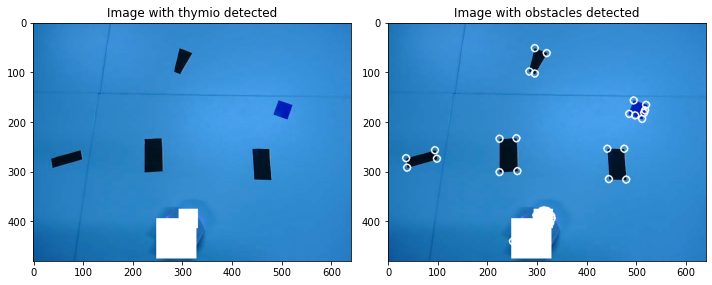

In [182]:
img = cv2.imread('pictures/map2.png')

img_thymio, start_coordinates, (center1, center2), test_detect = detect_start1(img, True)
gray, contours, shapes, shape_center = detect_obstacle(img)

fig, ax = plt.subplots(1, 2,figsize=(10, 8))
ax[0].imshow(img_thymio)
ax[1].imshow(img_obstacle)
ax[0].set_title("Image with thymio detected")
ax[1].set_title("Image with obstacles detected")
fig.tight_layout()
plt.show()

On the last images you can see that by using Hough's transform, we can detect obstacles and circles. It is important to notice that we need to apply some rectangles to mask the image before detecting obstacles. Here for the purpose of showing this, we did not apply rectangles on the target. As such, we can see that the target is detected as an obstacle whereas the circles aren't.

### 1.3 Template matching    <a class="anchor" id="template"></a>

Template matching is a technique used in image processing and computer vision to find instances of a template image in a larger image. It works by comparing the template image to multiple regions of the larger image, using a similarity measure such as normalized cross-correlation, to determine if the template is present in each region.  

To perform template matching, the template image is first converted into a binary image, where each pixel is either black or white. This is done by applying a threshold to the pixel intensities, so that pixels with intensities above the threshold are set to white and pixels below the threshold are set to black.  

Next, the template image is compared to multiple regions of the larger image using a similarity measure. The regions are typically smaller than the template image and are overlapped in order to ensure that all parts of the larger image are covered. The similarity measure is used to determine how closely the template image matches each region of the larger image.  

If a region of the larger image matches the template image above a certain threshold, it is considered to be a match. The location of the matching region is then recorded, and the process is repeated for the remaining regions of the larger image.  

Template matching is a useful technique for a variety of applications, such as object recognition, facial recognition, and pattern recognition. It is often used in conjunction with other image processing techniques, such as feature extraction and image segmentation, to improve the accuracy and efficiency of the matching process.  
 

<figure>
  <img src="pictures/template_match.jpg" width="700" alt="map" />
  <figcaption> <center> <u>Figure 5:</u> Template Matching using OpenCV <center> </figcaption></figure>

In [183]:
def detect_target(image):
    template = cv2.imread('Vision/feuille_rouge.png')
    #template = cv2.imread('feuille_rouge.png')
    _, w, h = template.shape[::-1]
    methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF',
               'cv2.TM_SQDIFF_NORMED']

    img = image.copy()
    # Apply template Matching
    res = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)  # TM_SQDIFF
    _, _, min_loc, max_loc = cv2.minMaxLoc(res)  # take min if TM_SQDIFF or TM_SQDIFF_NORMED

    top_left = (max_loc[0], max_loc[1])
    bottom_right = (top_left[0] + w, top_left[1] + h)
    target_coordinates = (top_left[0] + w / 2, top_left[1] + h / 2)
    cv2.rectangle(img, top_left, bottom_right, (255, 255, 255),
                  -1)  # rect blue, draw rectangle 2 opp corner top left and bottom right

    return target_coordinates, img, res


If we use the previously written function we can detect the target represented by the red square. This technique is usefull as it can find coloured target withing a small step time. On the following cell we will show how we use template matching on the test image to detect the target.

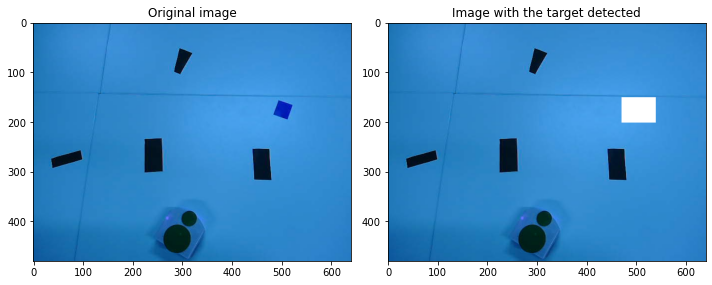

In [184]:
img = cv2.imread('pictures/map2.png')

target_coordinates, img_target, res = detect_target(img)

fig, ax = plt.subplots(1, 2,figsize=(10, 8))
ax[0].imshow(img)
ax[1].imshow(img_target)
ax[0].set_title("Original image")
ax[1].set_title("Image with the target detected")
fig.tight_layout()
plt.show()

[Table of content](#table)

## 2. Global Navigation   <a class="anchor" id="global_nav"></a>

### 2.0. Main functions    <a class="anchor" id="global_function"></a>

This part of the code is the second step of our code, its goal is to compute the shortest path from the starting position of the thymio to the target while avoiding obstacles. All the elements used in this part are given by the vision part of the code they are transmitted as points.

| Function of Global Navigation | Input | Output |
|:------|:------|:------|
|`build_vis_graph(shapes, start, target)` |Takes a list of points representing the contours of the obstacles and two points standing for the starting and finishing goal of the path. The path is made using pyVisgraph library and avoid obstacle using a visibility graph and a djisktra algorithm |The shortest path in the form of a list of points and the shapes representing the obstacles (also represented as points|


<u>Links of interest:</u>  
    - PyVisgraph library: https://github.com/TaipanRex/pyvisgraph  
    - D.T. Lee : https://taipanrex.github.io/2016/10/19/Distance-Tables-Part-2-Lees-Visibility-Graph-Algorithm.html  

### 2.1. PyVisgraph library   <a class="anchor" id="pyvisgraph"></a>

Given a set of simple obstacle polygons, build a visibility graph and find the shortest path between two points.
Pyvisgraph is a MIT-licensed Python package for building visibility graphs from a list of simple obstacle polygons. The visibility graph algorithm (D.T. Lee) runs in O(N² log(N)) time. The shortest path is found using Djikstra's algorithm.

| Function of PyVisgraph Library | Input | Output |
|:------|:------|:------|
|`VisGraph()` |Nothing| Return the created instance of the visibility graph|
|`build()` |Method of the instance of visibility graph. Takes in a list of points representing the obstacles| Returns nothing but add all the points to the existing visibility graph|
|`shortest_path()` |Method of the VisGraph instance (here g).Takes in a target and a starting point under the form of Point(from the visGraph library)| Return the shortest path linking the starting point to the target under the form of a list of checkpoints.|

In the following cell you can find the pseudo code useful to create the shortest path:

### 2.2 Implementation of the code   <a class="anchor" id="global_code"></a>

We will know demonstrate how one can find the shortest path using the pyVisgraph library using the functions in the vision part. For this test we use the following image 

<figure>
  <img src="pictures/map2.png" width="400" alt="map" />
  <figcaption> <center> <u>Figure 6:</u> Picture of test obstacles<center> </figcaption></figure>

The link between the Vision and the global navigation is made by the function of vision transmit_data() which returns the starting and target points and the obstacles. These data will be used in the creation of the visibility graph after.

In [185]:
def transmit_data(image, show, margin):
    img_start, start_coor, (center1, center2), test_detect = detect_start1(image)
    target_coor, img_target, res_target = detect_target(img_start)
    gray2, contours, shapes, shape_center = detect_obstacle(img_target)
    for i in range(len(shapes)):
        shapes[i] = vs.sort_vertices_clockwise(shapes[i])
    shapes = add_margin(shapes, shape_center, margin)

    if show:
        # Bilateral Filtering
        bilateral = cv2.bilateralFilter(image, 9, 75, 75)
        bw_img = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row')
        ax1.imshow(image)
        ax2.imshow(img_target)
        ax3.imshow(gray2)

        plt.title("img, start, target")

        plt.show()

    sz_img = np.shape(image)
    return start_coor, target_coor, shapes, sz_img, (center1, center2)

#### 2.2.1. The Dijkstra's algorithm:  <a class="anchor" id="djisktra"></a>

The Dijkstra's algorithm is a popular graph traversal algorithm that is used to find the shortest path between two nodes in a graph. It was developed by Dutch computer scientist Edsger Dijkstra in the 1950s and is widely used in computer science and other fields.  

The algorithm works by starting at the source node and exploring the neighboring nodes first, before moving on to the next-closest nodes. It uses a priority queue to keep track of the order in which the nodes are visited, and updates the distances between the nodes as it progresses. The algorithm terminates when the destination node is reached or when there are no more unexplored nodes.  

One way to visualize the algorithm is to think of it as a tree, where the source node is at the root and the destination node is a leaf. The algorithm moves from the root to the leaves, always choosing the shortest path to the next node.  


<figure>
  <img src="pictures/djisktra.png" width="400" alt="map" />
  <figcaption> <center> <u>Figure 7:</u> Djisktra graph<center> </figcaption></figure>

Here is an example of how the algorithm might work with A and J as the extremities of the graph:
- Start at the source node (A)
- Explore the neighboring nodes (B and C)
- Choose the closest neighboring node (B) and visit it
- Explore the neighboring nodes of B (D and E)
- Choose the closest neighboring node (E) and visit it
- Explore the neighboring nodes of D (F and D)
- Choose the closest neighboring node (F) and visit it
- Continue exploring the nodes until the destination node (K) is reached. Here J is the last node. Hence, we stop the algorithm.

In this example, the algorithm would visit the nodes in the following order: A -> B -> E -> F. This is the shortest path between the source and destination nodes.


#### 2.2.2. Visibility graph: <a class="anchor" id="visibility"></a>

A visibility graph is a type of graph that is used to represent the visibility between points in a plane. It is constructed by creating a vertex for each point in the plane, and then connecting two vertices with an edge if the corresponding points are visible to each other. This means that an edge exists between two vertices if there is a straight line between the points that does not intersect any other points in the plane.  

Visibility graphs are commonly used in computational geometry to solve a variety of problems, such as computing the shortest path between two points or finding the convex hull of a set of points. They are also used in other fields, such as robotics and computer graphics, where the visibility between points is important.  

One of the key benefits of visibility graphs is that they can be easily constructed from a set of points in the plane. This makes them a useful tool for solving problems that involve visibility, as they provide a simple and intuitive way to represent the relationships between the points. Additionally, visibility graphs can be used to solve problems that may be difficult or impossible to solve using other methods.  


<figure>
  <img src="pictures/visibility.png" width="400" alt="map" />
  <figcaption> <center> <u>Figure 8:</u> Djisktra graph<center> </figcaption></figure>

Now that we understand the theory behind Djisktra's algorithm and Visibility graphs, we can apply the first to the last one to compute the shortest path of our thymio in the map given by the vision functions. This is implemented by the following function build_vis_graph().  

The build_vis_graph() function takes in the parameter described in the next cell and by using the functions from the pyVisgraph library described in section 2.2 process the shortest path with the Djisktra algorithm.  

In [186]:
def build_vis_graph(shapes, start, target):
    """
    Take the information extracted to compute the shortest path using visibility graphs algorithms
    :param shapes: List of all obstacles
    :param start: Starting position of the robot
    :param target: Goal identified
    :return: The shortest path to go to the goal from the initial position
    """
    startx = str(start[0])
    starty = str(start[1])

    start = vg.Point(startx, starty)
    target = vg.Point(str(target[0]), str(target[1]))
    vgPoints = []

    for i in range(len(shapes)):
        temp = []
        for j in range(len(shapes[i])):
            temp.append(vg.Point(shapes[i][j][0], shapes[i][j][1]))
        temp.append(vg.Point(shapes[i][0][0], shapes[i][0][1]))
        vgPoints.append(temp)

    g = vg.VisGraph()
    g.build(vgPoints)

    shortest_path = g.shortest_path(start, target)
    return shortest_path, shapes

With these two functions we can have the shortest path. But is is clear if we look at the figure 5 that our robot will hit the obstacle due to its width. Therefore we have to add a certain margin to our obstacles. This is implemented by the following function add_margin()

In [187]:
def add_margin(coin, listCenters, margin):  # recoit shapes avec les vertices sort clockwise, return les nouveaux points aves la marge
    for i in range(len(coin)):
        for j in range(len(coin[i])):
            u = coin[i][j] - listCenters[i]
            u_norm = u / np.linalg.norm(u)
            coin[i][j] = coin[i][j] + margin*u_norm
    return coin

In the following code we display the shortest path. We can see clearly the effect of the add_margin() function. The corners of the obstacles are displaced to avoid the problems raised before. One of the advantage of the visibility graph technique is its complexity. Indeed you can test after and see how fast the shortest path is computed.

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.06it/s]


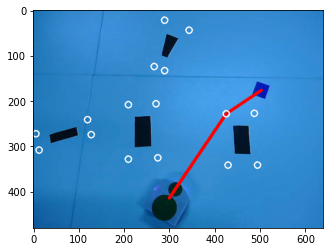

In [188]:
img = cv2.imread('pictures/map2.png')

start, target, shapes, size, start_points = transmit_data(img, False, 30)
shortest, shapes = build_vis_graph(shapes, start, target)

img = glb.draw_path(img, shortest)
for i in range(len(shapes)):
    for j in range(len(shapes[i])):
        cv2.circle(img, (int(shapes[i][j][0]), int(shapes[i][j][1])), 7, (255,255,255), 2)
plt.imshow(img)
plt.show()

[Table of content](#table)

## 3. Motion Control <a class="anchor" id="motion"></a>

### 3.1 Astolfi Controller <a class="anchor" id="astolfi"></a>

For the motion controller of the thymio, we opted for an Astolfi controller, which takes as input the coordinates of the thymio, its orientation, and the coordinates of the target location.
It then computes the following coordinates :
- $\rho$ : the distance from the thymio to the goal.
- $\alpha$ : the angle between the straight direction from the thymio to the goal, and the direction along thymio's orientation.
- $\beta$ : the orientation of the vector leading from the thymio to the goal.

These three coordinates can be seen in the image below:

<figure>
  <img src="pictures/Astolfi_schema.png" width="600" alt="map" />
  <figcaption> <center> <u>Figure 9:</u> Astolfi Schema <center> </figcaption></figure>

and they can be computed with the following relationships :

\begin{cases}  
\rho= \sqrt{\Delta x^2 + \Delta y^2} \\
\alpha = - \theta + atan2(\Delta y, \Delta x)  \\
\beta = - \theta - \alpha
\end{cases} 

where :
- $\Delta$x : the distance on the x axis from the thymio to the goal.
- $\Delta$y : the distance on the y axis from the thymio to the goal.
- $\theta$ : orientation of the thymio.

It can be shown that the control law : $v=k_\rho \times \rho$ and $\omega=k_\beta \times \beta + k_\alpha \times \alpha$ yields a closed loop system with a unique equilibrium point at $(\rho,\alpha,\beta)=(0,0,0)$, which are the coordinates we want to reach, and that this system is exponentially stable if: $k_\rho>0$, $k_\beta<0$, and $k_\alpha-k_\rho>0$. this set of equation had to be slighlty modified to take into account the flipped y-axis when working directly with pixels.

In our implementation of the Astolfi controller, we chose the coefficient $k_\beta$ to be as close to zero as possible, since this coefficient only affects the orientation of the thymio when it reaches its destination, which doesn't matter in the scope of our project. we also established a distance threshold so the thymio detects when it reaches its destination, and an angle threshold to avoid too much "zig-zagging". Lastly, since the speed is directly proportional to $\rho$, we had to establish and upper and lower limit to the speed in order to avoid speeds that are either too high or too low.

In [189]:
'''controller constants to tune accordingly'''
kp = 0.5  # >0
ka = 25  # > kp
kb = -0.01  # <0

'''speed limits and sensors thresholds to tune accordingly'''
v_max = 200
v_min = 20
thres_arrived = 50
angle_thres = 0.17
obstSpeedGain = np.array([6,4,-2,-6,-8])/100

'''Controller function'''
def astolfi(pos, theta, target, node, client):
    state = 0  # this functions is called recursivly untill state=1 i.e. the thymio has arrived
    delta_pos = [target[0] - pos[0], -(target[1] - pos[1])]
    rho = np.linalg.norm(delta_pos)
    alpha = -theta - np.arctan2(delta_pos[1], delta_pos[0])
    if alpha>np.pi:
        alpha-=2*np.pi
    elif alpha<-np.pi:
        alpha+=2*np.pi
    beta = theta - alpha
    if beta>np.pi:
        beta-=2*np.pi
    elif beta<-np.pi:
        beta+=2*np.pi
    sensors= np.array(get_prox_sensors(node, client)[0:5])
    vit_obst_left=np.sum(np.multiply(sensors,obstSpeedGain))
    vit_obst_right=np.sum(np.multiply(sensors,np.flip(obstSpeedGain)))
    #print("teta=",theta,"  alpa=",alpha,"  beta=",beta,"  rho=",rho) #prints to debug
    
    if (alpha>angle_thres):
        omega = ka * alpha + kb * beta
    else: 
        omega=kb*beta
    
    omega = ka * alpha + kb * beta
    if rho > thres_arrived:
        v = kp * rho
        if v > v_max: v = v_max
        if v < v_min: v = v_min
    else:
        v = 0
        state = 1
    left_speed = v - omega + vit_obst_left
    right_speed = v + omega + vit_obst_right
    set_motor_speed(int(right_speed), int(left_speed), node)
    return state

### 3.2 Auxiliary control functions <a class="anchor" id="control_aux"></a>


We also created some auxiliary motion control functions to help control the thymio, which will be quickly described in the following section:

[Table of content](#table)

## 4. Local obstacle avoidance <a class="anchor" id="local_avoidance"></a>

The local obstacle avoidance was directly implemented in the thymios's controller by means of potential fields.
In the "astolfi" function displayed in the previous section,

[Table of content](#table)

## 5. Filtering <a class="anchor" id="filtering"></a>

[Table of content](#table)

## 6. Whole code  <a class="anchor" id="whole_code"></a>

[Table of content](#table)

## 7. Conclusion <a class="anchor" id="conclusion"></a>

[Table of content](#table)